# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from comp451.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from comp451.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp451/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from comp451.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from comp451.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths ]

for lr, rg in grid_search:
    # Create a new SVM instance
    svm = LinearSVM()
    # Train the model with current parameters
    train_loss = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rg,
                      num_iters=1500, verbose=False)
    # Predict values for training set
    y_train_pred = svm.predict(X_train_feats)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = svm.predict(X_val_feats)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_svm = svm
    


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.092653 val accuracy: 0.072000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.103612 val accuracy: 0.119000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.416653 val accuracy: 0.418000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.112286 val accuracy: 0.108000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413367 val accuracy: 0.409000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.409735 val accuracy: 0.396000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415306 val accuracy: 0.414000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.406959 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.308694 val accuracy: 0.318000
best validation accuracy achieved during cross-validation: 0.418000


In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.428


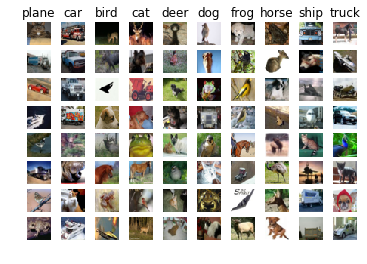

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ Misclassifications between cat, dog, deer and horse classes are understandable since they are similar to each other with respect to both edges and colors. Same logic can be used in the plane and bird example too. The misclassifications between truck and horse doesn't make sense. Neither the colors and edges are alike. I believe that color histogram and HOG are not enough to make accurate classifications. 




## Neural Network on image features
Earlier in this assigment we saw that training a three-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 58% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [16]:
from comp451.classifiers.neural_net import ThreeLayerNet

np.random.seed(1)

input_dim = X_train_feats.shape[1]
hidden_dim = 300
num_classes = 10

net = ThreeLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a three-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Best Validation Accuracy I got: 0.603. Hyper-parameters:  (lr:0.8, reg:0.0001, batch: 400, hidden: 200, epoch:1000) 
# Define the hyper-parameter lists for iteration
learning_rates = [7e-1, 8e-1, 9e-1]
regularization_strengths = [1e-4, 1e-5, 1e-6]
batch_sizes = [100, 200, 300, 400]
hidden_layer_sizes = [50, 100, 200, 300]
num_epochs = [50, 500, 1000]

# define the grid search variable for easy scripting
grid_search = [ (lr,rs,batch_size, hidden_size, epochs) for lr in learning_rates for rs in regularization_strengths
               for batch_size in batch_sizes for hidden_size in hidden_layer_sizes for epochs in num_epochs]

# results: {[array of hyper-params], {training accuracy, validation accuracy}}
results = {} 
i = 0
best_val = -1
for (lr,rs,batch_size, hidden_size, epochs) in grid_search:
    # Keep the iteration
    i += 1
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=epochs, batch_size=batch_size,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=rs, verbose=False)
    
    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    # Get the training accuracy
    train_acc = (net.predict(X_train_feats) == y_train).mean()
    # Store the hyper-parameters and results in the results dict.
    results[(lr, rs, batch_size, hidden_size, epochs)] = (train_acc, val_acc)
    # Store the model with the best validation accuracy
    if best_val < val_acc:
        best_val = val_acc
        best_net = net
    # Print information
    print("[SEARCH ", i, "] Training Accuracy: ", train_acc, "  Validation Accuracy: ", val_acc)
    print("Hyper-parameters: ", (lr, rs, batch_size, hidden_size, epochs), "\n")
    
#Print final information about the best model
print("Best model has the validation accuracy of " , best_val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


[SEARCH  1 ] Training Accuracy:  0.09989795918367347   Validation Accuracy:  0.105
Hyper-parameters:  (0.7, 0.0001, 100, 50, 50) 

[SEARCH  2 ] Training Accuracy:  0.4119387755102041   Validation Accuracy:  0.41
Hyper-parameters:  (0.7, 0.0001, 100, 50, 500) 

[SEARCH  3 ] Training Accuracy:  0.5829591836734694   Validation Accuracy:  0.535
Hyper-parameters:  (0.7, 0.0001, 100, 50, 1000) 

[SEARCH  4 ] Training Accuracy:  0.5931224489795919   Validation Accuracy:  0.55
Hyper-parameters:  (0.7, 0.0001, 100, 100, 50) 

[SEARCH  5 ] Training Accuracy:  0.606   Validation Accuracy:  0.545
Hyper-parameters:  (0.7, 0.0001, 100, 100, 500) 

[SEARCH  6 ] Training Accuracy:  0.6800612244897959   Validation Accuracy:  0.579
Hyper-parameters:  (0.7, 0.0001, 100, 100, 1000) 

[SEARCH  7 ] Training Accuracy:  0.6821224489795918   Validation Accuracy:  0.558
Hyper-parameters:  (0.7, 0.0001, 100, 200, 50) 

[SEARCH  8 ] Training Accuracy:  0.6997959183673469   Validation Accuracy:  0.549
Hyper-parame

[SEARCH  64 ] Training Accuracy:  0.9992040816326531   Validation Accuracy:  0.57
Hyper-parameters:  (0.7, 1e-05, 200, 100, 50) 

[SEARCH  65 ] Training Accuracy:  0.9998775510204082   Validation Accuracy:  0.572
Hyper-parameters:  (0.7, 1e-05, 200, 100, 500) 

[SEARCH  66 ] Training Accuracy:  0.9999795918367347   Validation Accuracy:  0.574
Hyper-parameters:  (0.7, 1e-05, 200, 100, 1000) 

[SEARCH  67 ] Training Accuracy:  0.999938775510204   Validation Accuracy:  0.573
Hyper-parameters:  (0.7, 1e-05, 200, 200, 50) 

[SEARCH  68 ] Training Accuracy:  1.0   Validation Accuracy:  0.569
Hyper-parameters:  (0.7, 1e-05, 200, 200, 500) 

[SEARCH  69 ] Training Accuracy:  1.0   Validation Accuracy:  0.569
Hyper-parameters:  (0.7, 1e-05, 200, 200, 1000) 

[SEARCH  70 ] Training Accuracy:  1.0   Validation Accuracy:  0.568
Hyper-parameters:  (0.7, 1e-05, 200, 300, 50) 

[SEARCH  71 ] Training Accuracy:  1.0   Validation Accuracy:  0.57
Hyper-parameters:  (0.7, 1e-05, 200, 300, 500) 

[SEARCH 

[SEARCH  134 ] Training Accuracy:  1.0   Validation Accuracy:  0.568
Hyper-parameters:  (0.7, 1e-06, 400, 50, 500) 

[SEARCH  135 ] Training Accuracy:  1.0   Validation Accuracy:  0.568
Hyper-parameters:  (0.7, 1e-06, 400, 50, 1000) 

[SEARCH  136 ] Training Accuracy:  1.0   Validation Accuracy:  0.568
Hyper-parameters:  (0.7, 1e-06, 400, 100, 50) 

[SEARCH  137 ] Training Accuracy:  1.0   Validation Accuracy:  0.567
Hyper-parameters:  (0.7, 1e-06, 400, 100, 500) 

[SEARCH  138 ] Training Accuracy:  1.0   Validation Accuracy:  0.567
Hyper-parameters:  (0.7, 1e-06, 400, 100, 1000) 

[SEARCH  139 ] Training Accuracy:  1.0   Validation Accuracy:  0.567
Hyper-parameters:  (0.7, 1e-06, 400, 200, 50) 

[SEARCH  140 ] Training Accuracy:  1.0   Validation Accuracy:  0.566
Hyper-parameters:  (0.7, 1e-06, 400, 200, 500) 

[SEARCH  141 ] Training Accuracy:  1.0   Validation Accuracy:  0.565
Hyper-parameters:  (0.7, 1e-06, 400, 200, 1000) 

[SEARCH  142 ] Training Accuracy:  1.0   Validation Accur

[SEARCH  197 ] Training Accuracy:  0.8085714285714286   Validation Accuracy:  0.552
Hyper-parameters:  (0.8, 1e-05, 100, 100, 500) 

[SEARCH  198 ] Training Accuracy:  0.8463877551020408   Validation Accuracy:  0.542
Hyper-parameters:  (0.8, 1e-05, 100, 100, 1000) 

[SEARCH  199 ] Training Accuracy:  0.8374081632653061   Validation Accuracy:  0.531
Hyper-parameters:  (0.8, 1e-05, 100, 200, 50) 

[SEARCH  200 ] Training Accuracy:  0.8532448979591837   Validation Accuracy:  0.558
Hyper-parameters:  (0.8, 1e-05, 100, 200, 500) 

[SEARCH  201 ] Training Accuracy:  0.8721836734693877   Validation Accuracy:  0.548
Hyper-parameters:  (0.8, 1e-05, 100, 200, 1000) 

[SEARCH  202 ] Training Accuracy:  0.8646122448979592   Validation Accuracy:  0.539
Hyper-parameters:  (0.8, 1e-05, 100, 300, 50) 

[SEARCH  203 ] Training Accuracy:  0.8671632653061224   Validation Accuracy:  0.544
Hyper-parameters:  (0.8, 1e-05, 100, 300, 500) 

[SEARCH  204 ] Training Accuracy:  0.8908571428571429   Validation Ac

[SEARCH  264 ] Training Accuracy:  1.0   Validation Accuracy:  0.58
Hyper-parameters:  (0.8, 1e-06, 200, 300, 1000) 

[SEARCH  265 ] Training Accuracy:  1.0   Validation Accuracy:  0.58
Hyper-parameters:  (0.8, 1e-06, 300, 50, 50) 

[SEARCH  266 ] Training Accuracy:  1.0   Validation Accuracy:  0.582
Hyper-parameters:  (0.8, 1e-06, 300, 50, 500) 

[SEARCH  267 ] Training Accuracy:  1.0   Validation Accuracy:  0.581
Hyper-parameters:  (0.8, 1e-06, 300, 50, 1000) 

[SEARCH  268 ] Training Accuracy:  1.0   Validation Accuracy:  0.582
Hyper-parameters:  (0.8, 1e-06, 300, 100, 50) 

[SEARCH  269 ] Training Accuracy:  1.0   Validation Accuracy:  0.582
Hyper-parameters:  (0.8, 1e-06, 300, 100, 500) 

[SEARCH  270 ] Training Accuracy:  1.0   Validation Accuracy:  0.582
Hyper-parameters:  (0.8, 1e-06, 300, 100, 1000) 

[SEARCH  271 ] Training Accuracy:  1.0   Validation Accuracy:  0.582
Hyper-parameters:  (0.8, 1e-06, 300, 200, 50) 

[SEARCH  272 ] Training Accuracy:  1.0   Validation Accuracy:

[SEARCH  329 ] Training Accuracy:  0.9999591836734694   Validation Accuracy:  0.589
Hyper-parameters:  (0.9, 0.0001, 400, 100, 500) 

[SEARCH  330 ] Training Accuracy:  0.9999795918367347   Validation Accuracy:  0.581
Hyper-parameters:  (0.9, 0.0001, 400, 100, 1000) 

[SEARCH  331 ] Training Accuracy:  0.9999795918367347   Validation Accuracy:  0.584
Hyper-parameters:  (0.9, 0.0001, 400, 200, 50) 

[SEARCH  332 ] Training Accuracy:  0.999938775510204   Validation Accuracy:  0.585
Hyper-parameters:  (0.9, 0.0001, 400, 200, 500) 

[SEARCH  333 ] Training Accuracy:  0.999938775510204   Validation Accuracy:  0.59
Hyper-parameters:  (0.9, 0.0001, 400, 200, 1000) 

[SEARCH  334 ] Training Accuracy:  0.9999183673469387   Validation Accuracy:  0.584
Hyper-parameters:  (0.9, 0.0001, 400, 300, 50) 

[SEARCH  335 ] Training Accuracy:  0.9996530612244898   Validation Accuracy:  0.588
Hyper-parameters:  (0.9, 0.0001, 400, 300, 500) 

[SEARCH  336 ] Training Accuracy:  0.9998979591836735   Validatio

[SEARCH  395 ] Training Accuracy:  1.0   Validation Accuracy:  0.575
Hyper-parameters:  (0.9, 1e-06, 100, 300, 500) 

[SEARCH  396 ] Training Accuracy:  1.0   Validation Accuracy:  0.575
Hyper-parameters:  (0.9, 1e-06, 100, 300, 1000) 

[SEARCH  397 ] Training Accuracy:  1.0   Validation Accuracy:  0.576
Hyper-parameters:  (0.9, 1e-06, 200, 50, 50) 

[SEARCH  398 ] Training Accuracy:  1.0   Validation Accuracy:  0.575
Hyper-parameters:  (0.9, 1e-06, 200, 50, 500) 

[SEARCH  399 ] Training Accuracy:  1.0   Validation Accuracy:  0.575
Hyper-parameters:  (0.9, 1e-06, 200, 50, 1000) 

[SEARCH  400 ] Training Accuracy:  1.0   Validation Accuracy:  0.575
Hyper-parameters:  (0.9, 1e-06, 200, 100, 50) 

[SEARCH  401 ] Training Accuracy:  1.0   Validation Accuracy:  0.577
Hyper-parameters:  (0.9, 1e-06, 200, 100, 500) 

[SEARCH  402 ] Training Accuracy:  1.0   Validation Accuracy:  0.576
Hyper-parameters:  (0.9, 1e-06, 200, 100, 1000) 

[SEARCH  403 ] Training Accuracy:  1.0   Validation Accura

In [18]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.576
